# **BANK OF AMERICA**

# Installation of the packages 



In [733]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [734]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl

import scipy.stats as si


## Download of the data from Yahoo Finance API

In [735]:
initial_data = yf.download(" BAC ", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [736]:
data=initial_data['Adj Close']
data.describe()

count    251.000000
mean      25.696392
std        3.752451
min       17.632553
25%       23.288668
50%       24.649536
75%       28.225950
max       36.200199
Name: Adj Close, dtype: float64

## Stock price plot

array([<AxesSubplot:xlabel='Date'>], dtype=object)

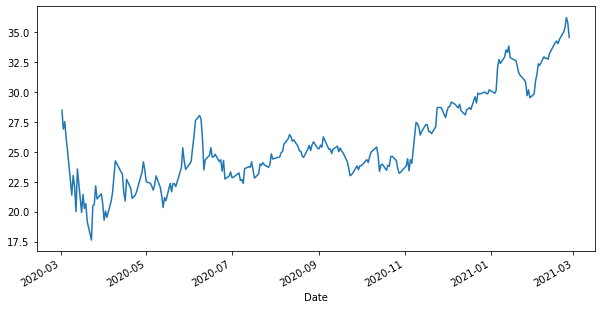

In [737]:
data.plot(figsize=(10, 5), subplots=True)

## Daily Log returns for 12 months period of data
### To calculate the Annualised Mean Return and the annualised volatility 

In [738]:
rets_12M = np.log(data / data.shift(1)) #Daily log return

MeanDReturn_12M = rets_12M.mean()
Ann_DRet_12M = MeanDReturn_12M*252
Ann_DRet_12M #Annualised Mean Return

0.19506752587696466

In [739]:
rets_12M.std() 
AnnStd_12=float(rets_12M.std())  #Standard deviation
AnnStd_12

0.03709234072804379

In [740]:
import math

AnnVol_12M = AnnStd_12*math.sqrt(252) #Annualised Volatility
AnnVol_12M

0.5888226546700583

## Download 6 month data to compare volatility 

In [741]:
initial_data2 = yf.download(" BAC ", start="2020-09-01", end="2021-03-01")

[*********************100%***********************]  1 of 1 completed


In [742]:
initial_data2['Adj Close'].tail()

Date
2021-02-22    34.976276
2021-02-23    35.344448
2021-02-24    36.200199
2021-02-25    35.752422
2021-02-26    34.538448
Name: Adj Close, dtype: float64

In [743]:
data2=initial_data2['Adj Close']
data6M=initial_data2['Adj Close']
data6M.describe()

count    124.000000
mean      28.058672
std        3.646040
min       23.001680
25%       24.660551
50%       28.225950
75%       30.809473
max       36.200199
Name: Adj Close, dtype: float64

array([<AxesSubplot:xlabel='Date'>], dtype=object)

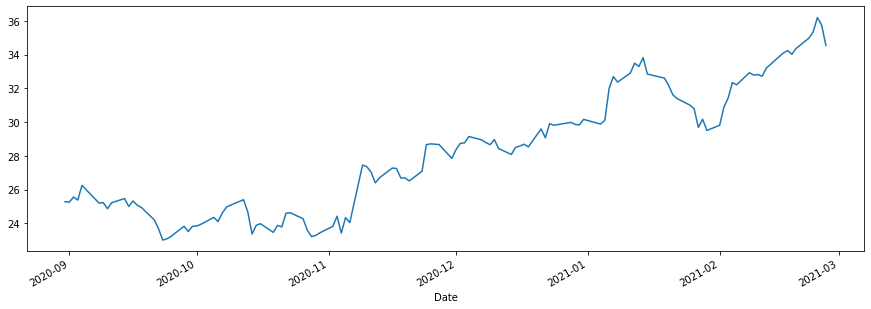

In [744]:
data6M.plot(figsize=(15, 5), subplots=True)

### Daily return and annualised volatility of 6 Months 

In [745]:
rets_6M = np.log(data2/ data2.shift(1)) #Daily log return

MeanDReturn_6M = rets_6M.mean()
Ann_DRet_6M = MeanDReturn_6M*252
Ann_DRet_6M #Annualised Mean Return

0.6394996598582823

In [746]:
rets_6M.std() 
AnnStd_6=float(rets_6M.std())  #Standard deviation
AnnStd_6

0.02277928845762163

In [747]:
AnnVol_6M = AnnStd_6*math.sqrt(252) #Annualised Volatility
AnnVol_6M

0.36160999381122555

# Analysis of the option value 

## Binomial Tree

In [748]:
import numpy as np
import os

In [943]:
S0 = 34.53              # spot stock price
K = 32.80               # strike
T = 1/12                  # maturity 
r = 0.0167              # risk free rate 
sig = 0.3616            # volatility (6M, in order to exclude noise from COVID Crash)
N = 4                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [820]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor

In [821]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [822]:
S

array([[34.53      , 36.30565118, 38.17261245, 40.13557927, 42.19948859],
       [ 0.        , 32.84119307, 34.53      , 36.30565118, 38.17261245],
       [ 0.        ,  0.        , 31.23498298, 32.84119307, 34.53      ],
       [ 0.        ,  0.        ,  0.        , 29.70733004, 31.23498298],
       [ 0.        ,  0.        ,  0.        ,  0.        , 28.25439217]])

In [823]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.49066783266199543

### Possible outcomes of the option:

In [825]:

S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
V[:,-1] = np.where (K>S_T,1,0.0) 
V

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

## For binary put

In [826]:
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[0.32620792, 0.13200333, 0.        , 0.        , 0.        ],
       [0.        , 0.51350165, 0.25925268, 0.        , 0.        ],
       [0.        , 0.        , 0.75875757, 0.50916862, 0.        ],
       [0.        , 0.        , 0.        , 0.9996789 , 1.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [828]:
print('Binary' + payoff, str( V[0,0]))

Binaryput 0.3262079158267749


## Monte Carlo Simulation

In [757]:
#Monte Carlo S

def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S

In [944]:


S0 = 34.53              # spot stock price
K = 32.80               # strike
T = 1/12                # maturity 
r = 0.0167              # risk free rate 
sigma = 0.3616            # volatility (6M, in order to exclude noise from COVID Crash)
N = 4                   # number of periods or number of time steps  
payoff = "put"          # payoff

In [945]:
S = mcs_simulation_np(10000)
S

array([[34.53      , 34.53      , 34.53      , ..., 34.53      ,
        34.53      , 34.53      ],
       [34.54620786, 34.52487848, 34.5232113 , ..., 34.57485954,
        34.58784131, 34.50653254],
       [34.55480182, 34.48005692, 34.58524847, ..., 34.53503904,
        34.6273166 , 34.52793754],
       ...,
       [36.23492574, 36.91065285, 33.94630653, ..., 34.67563323,
        39.24930402, 32.79858786],
       [36.17369525, 36.96977852, 33.93112225, ..., 34.73350576,
        39.25735332, 32.77787324],
       [36.16501126, 36.92180227, 33.98739804, ..., 34.70496448,
        39.21406945, 32.78254763]])

In [946]:
S = np.transpose(S)
S

array([[34.53      , 34.54620786, 34.55480182, ..., 36.23492574,
        36.17369525, 36.16501126],
       [34.53      , 34.52487848, 34.48005692, ..., 36.91065285,
        36.96977852, 36.92180227],
       [34.53      , 34.5232113 , 34.58524847, ..., 33.94630653,
        33.93112225, 33.98739804],
       ...,
       [34.53      , 34.57485954, 34.53503904, ..., 34.67563323,
        34.73350576, 34.70496448],
       [34.53      , 34.58784131, 34.6273166 , ..., 39.24930402,
        39.25735332, 39.21406945],
       [34.53      , 34.50653254, 34.52793754, ..., 32.79858786,
        32.77787324, 32.78254763]])

#### Price distribution of the underlying stock

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

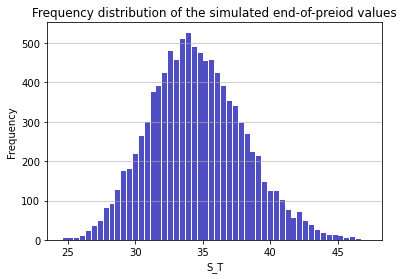

In [761]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

### Pricing value through Monte Carlo Simulation

In [830]:
p = np.mean(np.where (K>S_T,1,0.0))
print('Binary put', str(p))

#Takes maximum value compared to zero, the result is the average of the results.

Binary put 0.4


# GREEKS

In [777]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si

## 1. DELTA

In [839]:

def delta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    delta = -(np.exp(-r * T) * si.norm.pdf(d2, 0.0, 1.0)/ (vol * S * np.sqrt(T)))
    
    return delta

In [842]:
delta(34.53, 32.8, 1/12, 0.0167, 0.3616, 'put')

-0.09972473436844244

In [854]:
S = np.linspace(1,70)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 34.5, 1, 0.0167, 0.3505, 'call')
    Delta_Put [i] = delta(S[i], 34.5, 1, 0.0167, 0.3505, 'put')

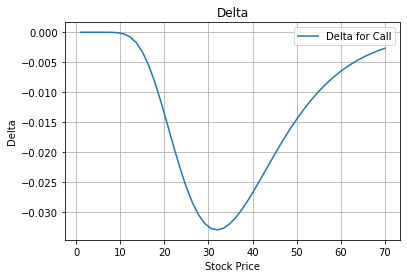

In [855]:
fig = plt.figure()
plt.plot(S, Delta_Put, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

## 2.GAMMA

In [861]:
def gamma(S, K, T, r, vol, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = (np.exp(-r * T) * d1 * si.norm.pdf(d2, 0.0, 1.0)) / ((vol ** 2) * (S ** 2) * T)

    
    return gamma

In [862]:
gamma(34.53, 32.8, 1/12, 0.0167 , 0.3616, 'put')

0.015436554073813849

In [864]:
S = np.linspace(15,70,90)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 32.8, 1/12, 0.0167, 0.3616, 'put')

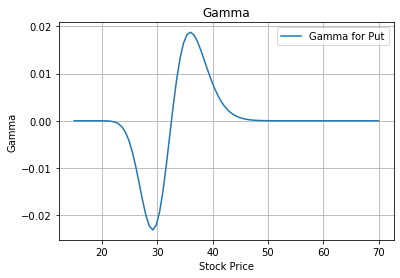

In [865]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Put'])

## 2.2 SPEED

In [882]:
def speed(S, K, T, r, vol, payoff):
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed_put= (np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)/(vol**2*S**3*T))*(-2*d1+(1-(d1*d2))/(vol*np.sqrt(T)))
    return speed_put

In [883]:
speed(34.53, 32.8, 1/12, 0.0167, 0.3616, 'put')


0.004839488329648772

In [884]:
S = np.linspace(20,40,50)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 32.8, 1/12, 0.0167, 0.3616, 'put')

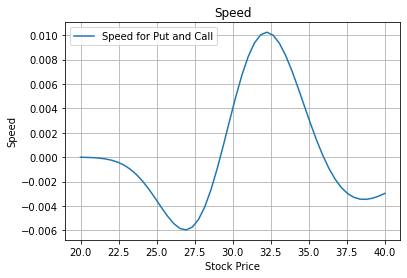

In [885]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Put and Call'])

## 3.THETA

In [905]:
def theta(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    theta_put =(r*np.exp(-r*T)*(1-si.norm.cdf(d2,0.0,1.0))-np.exp(-r*T)*si.norm.pdf(d2,0.0,1.0)*((d1/2*T)-(r/(vol*np.sqrt(T)))))

    return theta_put

In [906]:
theta(34.53, 32.8, 1/12, 0.0167, 0.3616, 'put')

0.05457142495881854

In [901]:
T = np.linspace(0.001,0.1)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(34.53, 32.8, T[i], 0.0167, 0.3616, 'call')
    Theta_Put [i] = theta(34.53, 32.8, T[i], 0.0167,  0.3616, 'put')

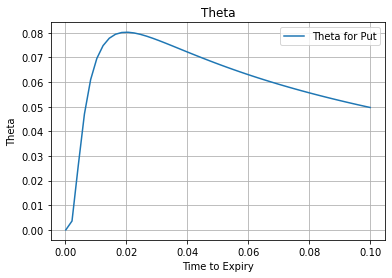

In [902]:
fig = plt.figure()

plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend([ 'Theta for Put'])

## 4.RHO

In [915]:
def rho(S, K, T, r, vol, payoff):
    
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    rho = - T * np.exp(-r * T) * (1-si.norm.cdf(d2,0.0,1.0)) -(si.norm.cdf(- np.sqrt(T)/ vol)* np.exp(-r * T) * (1-si.norm.pdf(d2,0.0,1.0)))   * (1-si.norm.pdf(d2,0.0,1.0)) 
    
    
    return rho

In [917]:
rho(34.53, 32.8, 1/12, 0.0167, 0.3616, 'put')

-0.1139194108879957

In [930]:
r = np.linspace(-0.01,.04)
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Put [i] = rho(34.53, 32.8, 1/12, r[i],  0.3616, 'put')

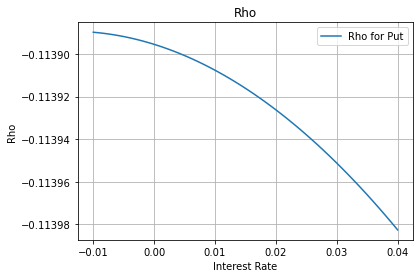

In [931]:
fig = plt.figure()
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend([ 'Rho for Put'])

## 5.VEGA

In [932]:
def vega(S, K, T, r, vol, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    vega = S * np.sqrt(T) * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [934]:
vega(34.53, 32.8, 1/12, 0.0167,  0.3616, 'put')

3.2620239112916742

In [941]:
vol = np.linspace(0.1,5)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(34.53, 32.8, 1/12, 0.0186, vol[i], 'put')

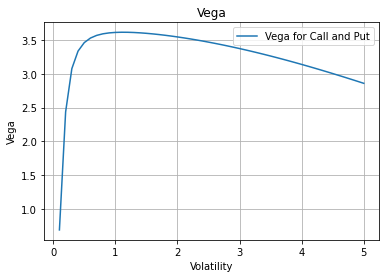

In [942]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

# STRATEGY ON BANK OF AMERICA 
## *Through Moving Average positions

In [808]:
initial_data = yf.download(" BAC, SPY ", start="2020-03-01", end="2021-03-01")

[*********************100%***********************]  2 of 2 completed


In [809]:
data =  initial_data['Adj Close']

In [810]:
rets = np.log(data / data.shift(1))

In [811]:
sym = 'BAC'
BAC_data = pd.DataFrame(data[sym]).dropna()


In [812]:
window = 10
BAC_data['min'] = data[sym].rolling(window=window).min()
BAC_data['mean'] = data[sym].rolling(window=window).mean()
BAC_data['std'] = data[sym].rolling(window=window).std()
BAC_data['median'] = data[sym].rolling(window=window).median()
BAC_data['max'] = data[sym].rolling(window=window).max()
BAC_data['ewma'] = data[sym].ewm(halflife=0.5, min_periods=window).mean()


In [813]:
BAC_data['SMA1'] = data[sym].rolling(window=20).mean()
BAC_data['SMA2'] = data[sym].rolling(window=60).mean()

<AxesSubplot:xlabel='Date'>

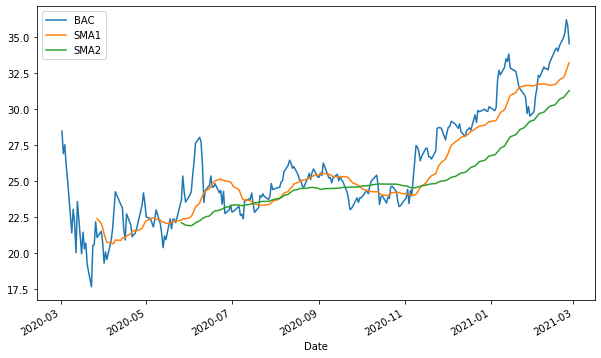

In [814]:
BAC_data[[sym, 'SMA1', 'SMA2']].plot(figsize=(10, 6))

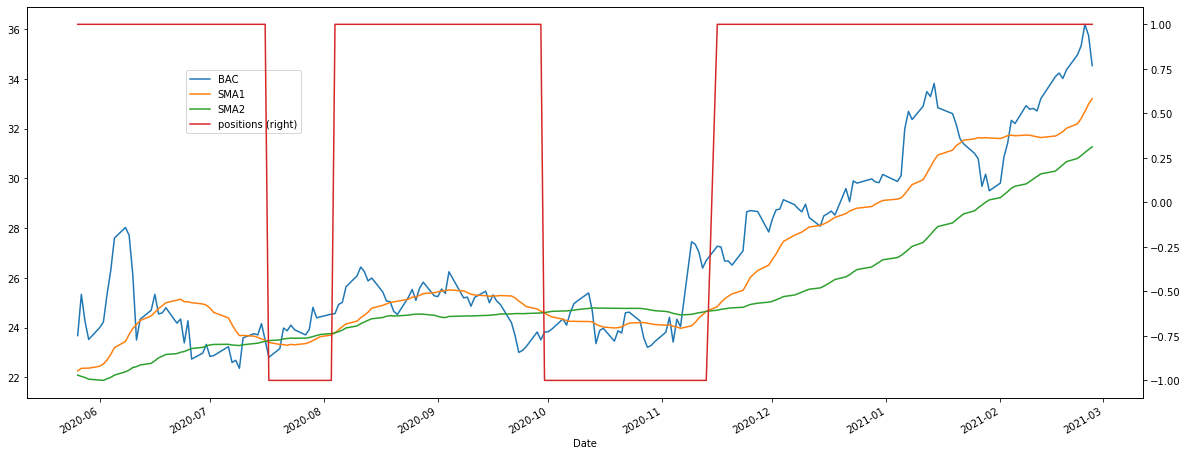

In [815]:
BAC_data.dropna(inplace=True)
BAC_data['positions'] = np.where(BAC_data['SMA1'] > BAC_data['SMA2'],1,-1)
ax = BAC_data[[sym, 'SMA1', 'SMA2', 'positions']].plot(figsize=(20, 8),secondary_y='positions')
ax.get_legend().set_bbox_to_anchor((0.25, 0.85))